## Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import random

## Function that reads the data

In [2]:
def get_data():
    # Path which our data is stored
    path = 'dns_oct-jan.csv'

    data = pd.read_csv(
             path,
             header=0
    )

    # Change to data type to datetime
    data['day'] = pd.to_datetime(data.day)

    # Keep necessary columns
    data = data[['shieldid', 'day', 'dns_qname', 'dns_qdomainname', 'num_clients', 'num_responses']]
    
    # drop the test shieldid
    bad_shield = 'haddomyev'
    data = data[data.shieldid != bad_shield]
    
    return data

In [3]:
data = get_data()

## Function transforms data into df

In [4]:
def get_df(data):    
    
    # df1 sums by domain name and day
    df1 = data.groupby(by=['dns_qdomainname','day']).sum()

    # df2 counts unique query names by domain name and day
    df2 = data.groupby(by=['dns_qdomainname','day'])[['shieldid','dns_qname']].nunique()
    df2 = pd.DataFrame(df2)
    df2.rename(columns={'shieldid': 'num_shieldid', 'dns_qname': 'num_dns_qname'}, inplace=True)
    
    # Concatenate df1 and df2 into df
    df = pd.concat([df1, df2], axis=1)
    df.reset_index(level=1, inplace=True)
    
    # Create Column with Generic popularity
    path = 'https://raw.githubusercontent.com/zer0h/top-1000000-domains/master/top-1000000-domains'
    top_domains = pd.read_csv(path, header=None, names=['dns_qdomainname'])
    rank = list(range(1, 1_000_001))
    top_domains['rank'] = rank
    top_domains.set_index('dns_qdomainname',inplace=True)
    df = df.join(top_domains, on='dns_qdomainname')
    
    # Merge with the transformed whois csv
    import re
    whois = pd.read_csv('whoisv1.csv')
    whois.set_index('domain', inplace=True)
    dfmerged = df.join(whois, on='dns_qdomainname')
    
    # Define data types
    dfmerged['registration_period'] = pd.to_numeric(dfmerged['registration_period'].str.replace(r'\D+', '', regex=True))
    dfmerged['day'] = pd.to_datetime(dfmerged['day'])
    dfmerged['created'] = pd.to_datetime(dfmerged['created'])
    dfmerged['updated'] = pd.to_datetime(dfmerged['updated'])
    dfmerged['expires'] = pd.to_datetime(dfmerged['expires'])
    
    return dfmerged

df = get_df(data)

In [5]:
df.head(5)

,day,num_clients,num_responses,num_shieldid,num_dns_qname,rank,created,updated,expires,whois,registration_period
dns_qdomainname,,,,,,,,,,,
*google.com,2022-10-02,1,2,1,1,NaN,NaT,NaT,NaT,NaN,NaN
*google.com,2022-10-03,1,2,1,1,NaN,NaT,NaT,NaT,NaN,NaN
*google.com,2022-10-04,1,2,1,1,NaN,NaT,NaT,NaT,NaN,NaN
*google.com,2022-10-10,1,1,1,1,NaN,NaT,NaT,NaT,NaN,NaN
*google.com,2022-10-11,3,115,2,1,NaN,NaT,NaT,NaT,NaN,NaN


In [6]:
def bin_and_merge(df, group_col, bin_col, bin_label):
    # Group by domain and sum the values for the given column
    group_by_domain = df.groupby(df.index)[bin_col].sum().reset_index()

    # Sort the data by ascending order
    group_by_domain.sort_values(by=bin_col, inplace=True)

    # Create the bin edges for 5 equal cuts
    bin_edges_a = pd.qcut(group_by_domain[bin_col], q=group_by_domain[bin_col].nunique(), duplicates='drop').sort_values().unique()

    # Create the bin labels
    bin_labels = [f"{int(bin_edges_a[i].left+1)}-{int(bin_edges_a[i].right)}" for i in range(len(bin_edges_a))]

    # Convert bin edges to floats
    bin_edges = [float(bin_edge.left) for bin_edge in bin_edges_a]
    bin_edges.append(float(bin_edges_a[-1].right))

    # Bin the data and assign the labels to each row
    group_by_domain['group'] = pd.cut(group_by_domain[bin_col], bins=bin_edges, labels=bin_labels)

    # Merge the labeled data back to the original dataframe
    df = pd.merge(df, group_by_domain[['dns_qdomainname', 'group']], on='dns_qdomainname', how='left')
    df.rename(columns={'group': bin_label}, inplace=True)
    df.set_index('dns_qdomainname', inplace=True)

    return df

# Apply the binning to different columns
df = bin_and_merge(df, 'dns_qdomainname', 'num_clients', 'client_sum_group')
df = bin_and_merge(df, 'dns_qdomainname', 'num_responses', 'responses_sum_group')
df = bin_and_merge(df, 'dns_qdomainname', 'num_shieldid', 'shield_sum_group')

In [7]:
import time
start_time = time.time()

# list the sum groups
sum_groups = [
    ("client_sum_group", "num_clients", "prob_obs_num_clients"),
    ("responses_sum_group", "num_responses", "prob_obs_num_responses"),
    ("shield_sum_group", "num_shieldid", "prob_obs_num_shield")
]

for group_col, num_col, prob_col in sum_groups:
    # loop over each sum group
    for group_val in df[group_col].sort_values().unique():
        # empty dictionary
        dict_ = {}
        # slice the df to sum group
        case = df.loc[df[group_col]==group_val]
        # create the number of bins so we get discrete bins
        num_bins = case[num_col].max()
        # cumulative distribution of the empirical observations
        pds, bins = np.histogram(case[num_col], bins=num_bins, density=False)
        probs = list(1 - (pds/np.sum(pds)).cumsum())
        probs.insert(0,1)
        probs.pop(-1)
        probs = np.array(probs)
        # list the integer bin values
        bins = list(bins)
        for i in range(len(bins)):
            bins[i] = int(i)
        bins.pop(0)
        bins = np.array(bins)
        if len(bins) == len(probs):
            # create dictionary
            dict_ = dict(zip(bins, probs))
            # replace the values in the column with dictionary values using apply
            df.loc[df[group_col] == group_val, prob_col] = case[num_col].apply(lambda x: dict_.get(int(x), 0))
            
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 105.96628308296204 seconds


# Issue with overreporting anomalies on days with high traffic

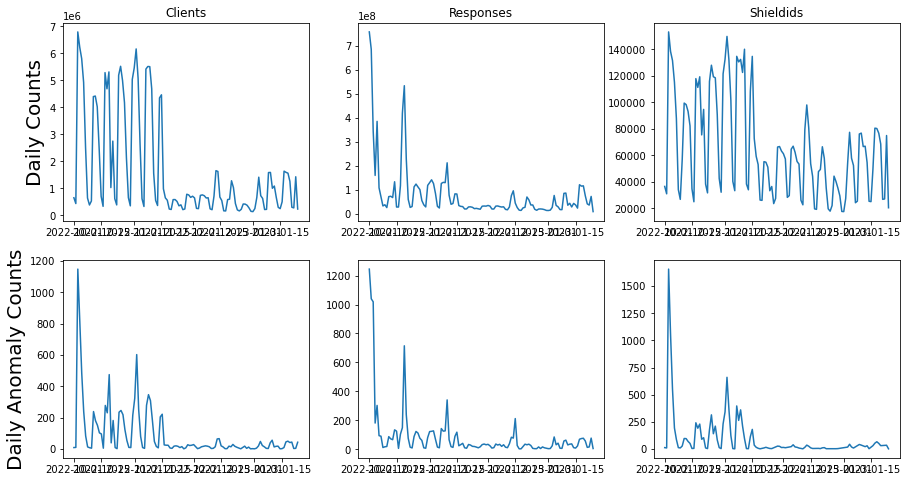

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
abc = df.groupby('day').num_clients.sum()
ax[0,0].plot(abc)
ax[0,0].set_title('Clients')
ax[0,0].set_ylabel('Daily Counts', fontsize=20)
abc = df.groupby('day').num_responses.sum()
ax[0,1].plot(abc)
ax[0,1].set_title('Responses')
abc = df.groupby('day').num_shieldid.sum()
ax[0,2].plot(abc)
ax[0,2].set_title('Shieldids')
ax[1,0].set_ylabel('Daily Anomaly Counts', fontsize=20)
abc = df.sort_values(by='prob_obs_num_clients').head(10000).day.value_counts().sort_index()
ax[1,0].plot(abc.index, abc)
abc = df.sort_values(by='prob_obs_num_responses').head(10000).day.value_counts().sort_index()
ax[1,1].plot(abc.index, abc)
abc = df.sort_values(by='prob_obs_num_shield').head(10000).day.value_counts().sort_index()
ax[1,2].plot(abc.index, abc)
plt.show()

In [9]:
lengthdf = df.shape[0]
df['client_norm'] = np.ones(lengthdf)
period = df.day.nunique()
totalclients = df.num_clients.sum()
days = list(sorted(df.day.unique()))
for day in days:
    daily = df.loc[df.day==day]['num_clients'].sum()
    df.loc[df.day==day, 'client_norm'] = df.loc[df.day==day, 'prob_obs_num_clients'] * daily / totalclients * period

In [10]:
df['response_norm'] = np.ones(lengthdf)
totalresponses = df.num_responses.sum()
for day in days:
    daily = df.loc[df.day==day]['num_responses'].sum()
    df.loc[df.day==day, 'response_norm'] = df.loc[df.day==day, 'prob_obs_num_responses'] * daily / totalresponses * period

In [11]:
df['shieldid_norm'] = np.ones(lengthdf)
totalshieldids = df.num_shieldid.sum()
for day in days:
    daily = df.loc[df.day==day]['num_shieldid'].sum()
    df.loc[df.day==day, 'shieldid_norm'] = df.loc[df.day==day, 'prob_obs_num_shield'] * daily / totalshieldids * period

## After normalizing

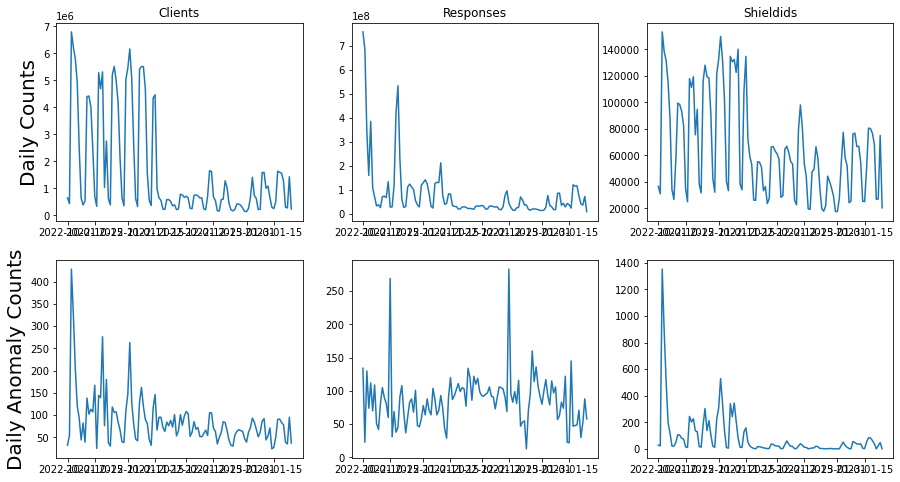

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
abc = df.groupby('day').num_clients.sum()
ax[0,0].plot(abc)
ax[0,0].set_title('Clients')
ax[0,0].set_ylabel('Daily Counts', fontsize=20)
abc = df.groupby('day').num_responses.sum()
ax[0,1].plot(abc)
ax[0,1].set_title('Responses')
abc = df.groupby('day').num_shieldid.sum()
ax[0,2].plot(abc)
ax[0,2].set_title('Shieldids')
ax[1,0].set_ylabel('Daily Anomaly Counts', fontsize=20)
abc = df.sort_values(by='client_norm').head(10000).day.value_counts().sort_index()
ax[1,0].plot(abc.index, abc)
abc = df.sort_values(by='response_norm').head(10000).day.value_counts().sort_index()
ax[1,1].plot(abc.index, abc)
abc = df.sort_values(by='shieldid_norm').head(10000).day.value_counts().sort_index()
ax[1,2].plot(abc.index, abc)
plt.show()

# Now, ranking anomalies: 0 is anomaly, 1 is normal.

In [56]:
lengthdf = len(df)
ranks = np.linspace(0,1,lengthdf)
df.sort_values(by='client_norm', inplace=True)
df['client_norm'] = ranks
df.sort_values(by='response_norm', inplace=True)
df['response_norm'] = ranks
df.sort_values(by='shieldid_norm', inplace=True)
df['shieldid_norm'] = ranks
df.sort_index(inplace=True)
df['normal_obs'] = df.client_norm*df.response_norm*df.shieldid_norm
df.sort_values(by='normal_obs', inplace=True)
df['normal_obs'] = ranks

In [57]:
cutoff = .01
top_anoms= df.sort_values(by='normal_obs').head(int(cutoff*lengthdf))

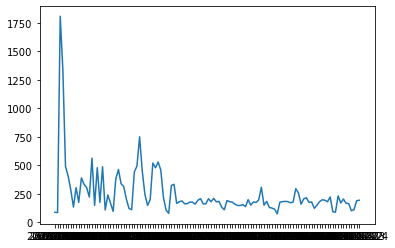

In [58]:
abc = top_anoms.day.value_counts().sort_index()
plt.plot(abc)

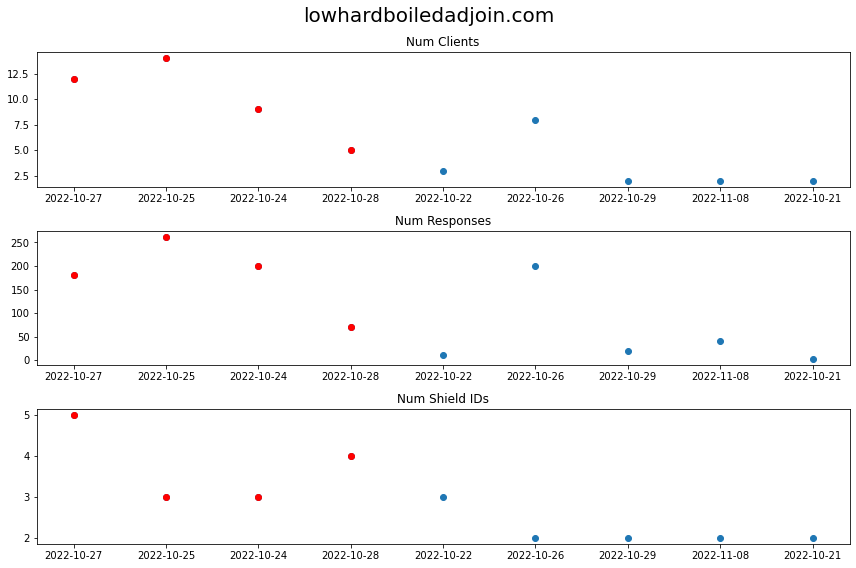

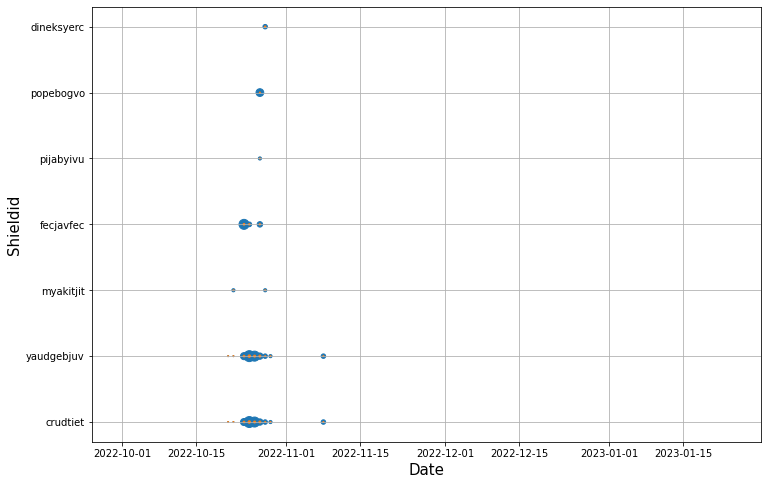

In [59]:
rs = random.sample(list(top_anoms.index.unique()),1)
domain = 'lowhardboiledadjoin.com'
test = df.loc[df.index==domain]
dom_anoms = top_anoms.loc[top_anoms.index==domain]

fig, axs = plt.subplots(3, 1, figsize=(12, 8))

axs[0].scatter(test.day, test.num_clients)
axs[0].set_title('Num Clients')
axs[0].scatter(dom_anoms.day, dom_anoms.num_clients, color='red')

axs[1].scatter(test.day, test.num_responses)
axs[1].set_title('Num Responses')
axs[1].scatter(dom_anoms.day, dom_anoms.num_responses, color='red')

axs[2].scatter(test.day, test.num_shieldid)
axs[2].set_title('Num Shield IDs')
axs[2].scatter(dom_anoms.day, dom_anoms.num_shieldid, color='red')

plt.suptitle(str(domain), fontsize=20)
plt.tight_layout()
plt.show()

def get_domain_case_new(data, domain_name):    
    
    datatemp = data.loc[data.dns_qdomainname==domain_name]
    
    # df1 sums by domain name and day
    df1 = datatemp.groupby(by=['dns_qdomainname','day','shieldid']).sum()

    # df2 counts unique query names by domain name and day
    df2 = datatemp.groupby(by=['dns_qdomainname','day','shieldid'])['dns_qname'].nunique()
    df2 = pd.DataFrame(df2)
    df2.rename(columns={'dns_qname': 'num_dns_qname'}, inplace=True)

    # Concatenate df1 and df2 into df
    domain_case_new = pd.concat([df1, df2], axis=1)
    domain_case_new.reset_index(level=1, inplace=True)
    domain_case_new.reset_index(level=1, inplace=True)
    
    from itertools import product

    # Create lists of all unique values in columns 
    l1 = [domain_name]
    l2 = list(data.day.unique())
    l3 = list(domain_case_new.shieldid.unique())
    l4 = [0]
    l5 = [0]
    l6 = [0]

    _ = pd.DataFrame(list(product(l1, l2, l3, l4, l5, l6)), columns=['dns_qdomainname', 'day', 'shieldid', 'num_clients', 'num_responses', 'num_dns_qname'])
    _.set_index(list(_)[0], inplace=True)

    domain_case_new = pd.concat([domain_case_new, _])

    domain_case_new = domain_case_new.sort_values('day')

    return domain_case_new

domain_case_new = get_domain_case_new(data, domain)

# Plot
plt.figure(figsize=(12,8))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Shieldid', fontsize=15)

plt.scatter(domain_case_new.day, domain_case_new.shieldid, s=domain_case_new.num_responses)
plt.scatter(domain_case_new.day, domain_case_new.shieldid, s=domain_case_new.num_clients)
plt.grid(axis='both')

In [60]:
df.to_csv('all_anom_probs.csv')

In [61]:
df = pd.read_csv('all_anom_probs.csv')
df.set_index('dns_qdomainname',inplace=True)

In [62]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

In [63]:
df['tld'] = df.index.str.split('.',expand=False).str[1]

In [146]:
df.prob_obs_num_clients.sort_values()

dns_qdomainname
mastercard.us             0.000053
bmt-industry.com          0.000077
upland.me                 0.000077
vodafone.es               0.000080
micro-semiconductor.hk    0.000084
                            ...   
3g.cn                     1.000000
amplify.ai                1.000000
windex.com                1.000000
layerhost.com             1.000000
ikeepapps.com             1.000000
Name: prob_obs_num_clients, Length: 2868986, dtype: float64

In [64]:
X = df[['rank', 'whois', 'registration_period', 'day', 'num_clients', 'num_responses', 'num_shieldid', 'num_dns_qname',
        'tld']]#, 'prob_obs_num_clients', 'prob_obs_num_responses', 'prob_obs_num_shield']]
y = df['normal_obs']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=500000)

In [137]:
# regression pipeline
cat_features = ['whois', 'tld', 'day']
num_features = ['rank', 'registration_period', 'num_clients', 'num_responses', 'num_shieldid', 'num_dns_qname',
                'prob_obs_num_clients', 'prob_obs_num_responses', 'prob_obs_num_shield']

cat_processor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

num_processor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=df['rank'].max())),
    ('scaler', MinMaxScaler())
])

feature_processor = ColumnTransformer(
    transformers=[
        ('categorical processor', cat_processor, cat_features),
        ('numerical processor', num_processor, num_features)
]
    ,remainder='drop')
    
pipe = Pipeline(steps=[
    ('feature_processor',feature_processor),
    ('poly_features',PolynomialFeatures(degree=2)),
    ('regression',SGDRegressor(alpha=0.1, loss='epsilon_insensitive'))
])

# fit the model to training set
pipe.fit(X_train,y_train)

Pipeline(steps=[('feature_processor',
                 ColumnTransformer(transformers=[('categorical processor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['whois', 'tld', 'day']),
                                                 ('numerical processor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=999926.0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['rank',
                                                   'registration_period',
                                                   'num_clients',
                                                   'num_responses',
                                                   'num_shieldid',
                                                   'num_dns_qname',
                                                   'prob_obs_num_clients',
                                                   'prob_obs_num_responses',
                                                   'prob_obs_num_shield'])])),
                ('poly_features', PolynomialFeatures()),
                ('regression',
                 SGDRegressor(alpha=0.1, loss='epsilon_insensitive'))])

In [138]:
y_pred = pipe.predict(X_test)
X_test['normal_obs_pred'] = y_pred
X_test.sort_values(by='normal_obs_pred', inplace=True)
X_test['normal_obs_pred'] = np.linspace(0,1,len(X_test))

In [139]:
X_test

,rank,whois,registration_period,day,num_clients,num_responses,num_shieldid,num_dns_qname,tld,prob_obs_num_clients,prob_obs_num_responses,prob_obs_num_shield,normal_obs,pred,normal_obs_pred
dns_qdomainname,,,,,,,,,,,,,,,
freethink.com,NaN,whois.godaddy.com,8035.0,2022-11-24,16,513,5,1,com,0.005548,0.010989,0.002325,0.000082,0.195104,0.000000e+00
yourdiy.com,NaN,whois.godaddy.com,2922.0,2022-12-30,27,136,3,4,com,0.037532,0.079159,0.071992,0.001043,0.228362,4.221217e-07
freethink.com,NaN,whois.godaddy.com,8035.0,2022-11-26,7,237,3,1,com,0.075728,0.028388,0.052425,0.000682,0.218880,8.442434e-07
freethink.com,NaN,whois.godaddy.com,8035.0,2022-11-25,11,202,5,1,com,0.017198,0.038919,0.002325,0.000228,0.204173,1.266365e-06
hitv.com,NaN,grs-whois.hichina.com,9131.0,2022-11-27,14,426,2,14,com,0.020530,0.007395,0.257821,0.000426,0.185798,1.688487e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mailappthree.com,NaN,NaN,NaN,2022-10-05,1,1,1,1,com,1.000000,1.000000,1.000000,0.992832,0.808861,9.999983e-01
readytrekgo.com.au,NaN,NaN,NaN,2022-10-05,1,1,1,1,com,1.000000,1.000000,1.000000,0.993665,0.808861,9.999987e-01
nutrymedica.com.mx,NaN,NaN,NaN,2022-10-05,1,1,1,1,com,1.000000,1.000000,1.000000,0.993900,0.808861,9.999992e-01


In [140]:
testdfs = X_test.sample(10000)

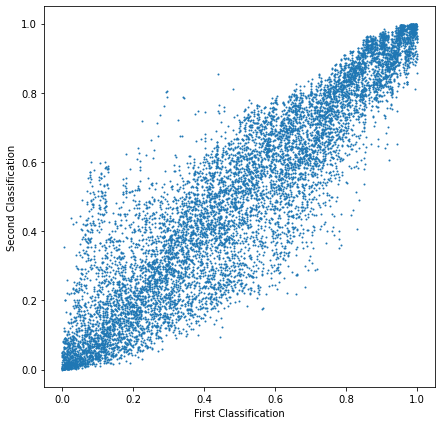

In [147]:
plt.figure(figsize=(7,7))
plt.scatter(testdfs.normal_obs, testdfs.normal_obs_pred, s = 1)
plt.xlabel('First Classification')
plt.ylabel('Second Classification')
plt.show()

In [142]:
from sklearn.metrics import r2_score
r2_score(X_test['normal_obs'], X_test['normal_obs_pred'])

0.8361549675626172

In [143]:
# Get the feature names from the column transformer
cat_features_encoded = pipe.named_steps['feature_processor'].transformers_[0][1].named_steps['encoder'].get_feature_names(cat_features)
feature_names = np.concatenate([cat_features_encoded, num_features])

# Pair the feature names with their corresponding coefficients
coef_tuples = sorted(zip(feature_names, pipe.named_steps['regression'].coef_), key=lambda x: abs(x[1]), reverse=True)

# Print the feature names and their corresponding coefficients
for feature, coef in coef_tuples:
    print(f"{feature}: {coef}")

prob_obs_num_shield: 0.16711882982518864
prob_obs_num_responses: 0.13817950543790095
day_2022-10-20: 0.06046945874034925
day_2022-10-06: 0.06036120838052713
day_2022-10-19: 0.05759922501060981
day_2022-11-09: 0.05586103567900964
day_2022-11-04: 0.0554086200766002
day_2022-11-10: 0.054645693492495005
day_2022-10-04: 0.05453187143942867
day_2022-11-08: 0.054160055885050455
day_2022-11-03: 0.05397498884482536
day_2022-11-02: 0.053828709974741026
day_2022-11-11: 0.05379865316727224
day_2022-10-26: 0.05320755994446992
day_2022-10-27: 0.04984938753310749
day_2022-11-01: 0.04916106249713265
day_2022-10-25: 0.04866570816897284
day_2022-10-05: 0.04811467266847213
day_2022-11-16: 0.04742410809068231
day_2022-10-18: 0.04735899377463335
day_2022-10-07: 0.045390231015414485
day_2022-10-28: 0.045244751004682005
day_2022-12-05: -0.043387702084075
whois_202.105.21.240: 0.04261639068251141
day_2022-11-15: 0.04117513817318875
day_2022-12-11: -0.04107361783938889
day_2022-11-12: 0.040728140188866814
day_

/Users/lukewyman/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [170]:
# Overclassified in first classification?
# capturing High first classification, Low second classification
# Top Right
TR = X_test.loc[(X_test.normal_obs>.01)&(X_test.normal_obs_pred<.01)]

In [171]:
# Capturing more in Second classification?
# capturing Low first classification, High second classification
# Bottom Left
BL = X_test.loc[(X_test.normal_obs<.01)&(X_test.normal_obs_pred>.01)]

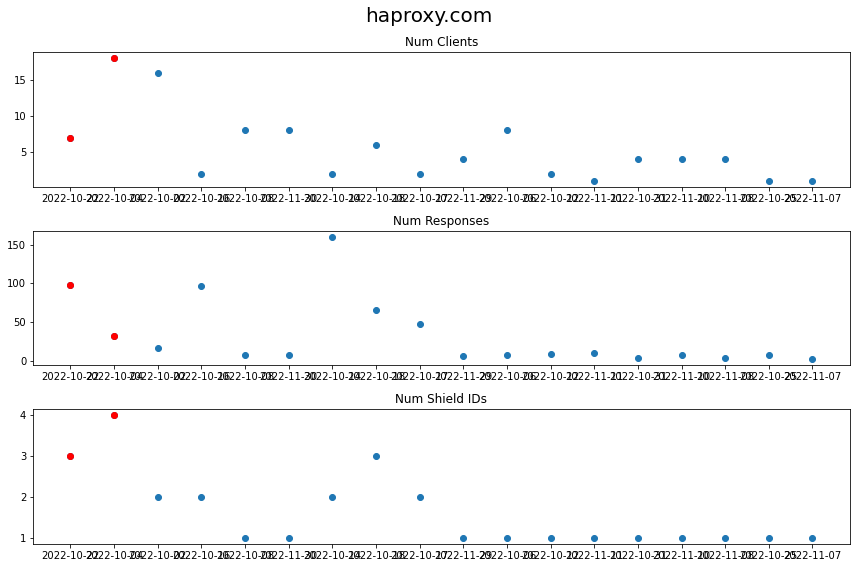

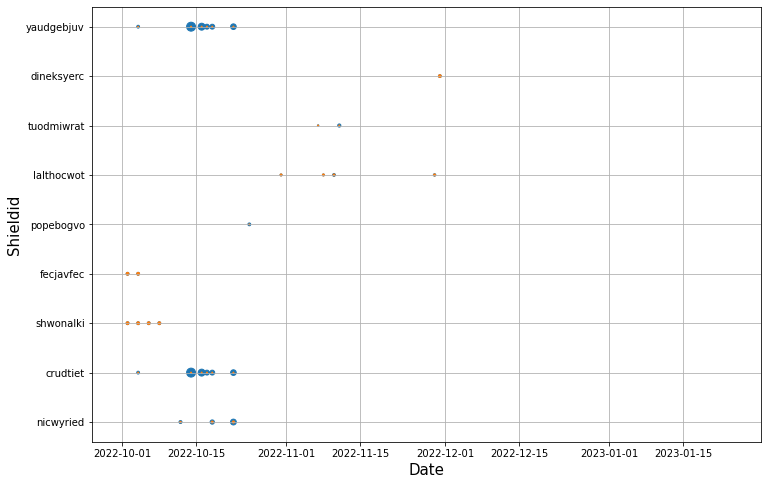

In [179]:
domain = TR.sample(1).index[0]
test = df.loc[df.index==domain]
dom_anoms = top_anoms.loc[top_anoms.index==domain]

fig, axs = plt.subplots(3, 1, figsize=(12, 8))

axs[0].scatter(test.day, test.num_clients)
axs[0].set_title('Num Clients')
axs[0].scatter(dom_anoms.day, dom_anoms.num_clients, color='red')

axs[1].scatter(test.day, test.num_responses)
axs[1].set_title('Num Responses')
axs[1].scatter(dom_anoms.day, dom_anoms.num_responses, color='red')

axs[2].scatter(test.day, test.num_shieldid)
axs[2].set_title('Num Shield IDs')
axs[2].scatter(dom_anoms.day, dom_anoms.num_shieldid, color='red')

plt.suptitle(str(domain), fontsize=20)
plt.tight_layout()
plt.show()

def get_domain_case_new(data, domain_name):    
    
    datatemp = data.loc[data.dns_qdomainname==domain_name]
    
    # df1 sums by domain name and day
    df1 = datatemp.groupby(by=['dns_qdomainname','day','shieldid']).sum()

    # df2 counts unique query names by domain name and day
    df2 = datatemp.groupby(by=['dns_qdomainname','day','shieldid'])['dns_qname'].nunique()
    df2 = pd.DataFrame(df2)
    df2.rename(columns={'dns_qname': 'num_dns_qname'}, inplace=True)

    # Concatenate df1 and df2 into df
    domain_case_new = pd.concat([df1, df2], axis=1)
    domain_case_new.reset_index(level=1, inplace=True)
    domain_case_new.reset_index(level=1, inplace=True)
    
    from itertools import product

    # Create lists of all unique values in columns 
    l1 = [domain_name]
    l2 = list(data.day.unique())
    l3 = list(domain_case_new.shieldid.unique())
    l4 = [0]
    l5 = [0]
    l6 = [0]

    _ = pd.DataFrame(list(product(l1, l2, l3, l4, l5, l6)), columns=['dns_qdomainname', 'day', 'shieldid', 'num_clients', 'num_responses', 'num_dns_qname'])
    _.set_index(list(_)[0], inplace=True)

    domain_case_new = pd.concat([domain_case_new, _])

    domain_case_new = domain_case_new.sort_values('day')

    return domain_case_new

domain_case_new = get_domain_case_new(data, domain)

# Plot
plt.figure(figsize=(12,8))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Shieldid', fontsize=15)

plt.scatter(domain_case_new.day, domain_case_new.shieldid, s=domain_case_new.num_responses)
plt.scatter(domain_case_new.day, domain_case_new.shieldid, s=domain_case_new.num_clients)
plt.grid(axis='both')